In [3]:
import cartopy
print(cartopy.__version__)
import matplotlib
print(matplotlib.__version__)
# import numpy
# print(numpy.__version__)

0.18.0
3.2.2


In [4]:
from netCDF4 import Dataset
import pickle
from scipy.stats import pearsonr
import mask
from cartoplot import cartoplot
from field_importer import get_field
from scipy.interpolate import NearestNDInterpolator
import scipy.interpolate
import numpy as np
from tqdm import trange
from scipy.stats import linregress
import xarray as xr
from collections import defaultdict
import numpy.ma as ma
from mask import select_region
import cartopy.crs as ccrs
import cartopy
from select_type import select_type
import matplotlib.pyplot as plt
from math import sqrt
from matplotlib.transforms import ScaledTranslation
import warnings
import datetime
import itertools
month_names = []
for i in range(1,13):
    month_names.append((i, datetime.date(2008, i, 1).strftime('%B'))[1][:3])
print(month_names)

warnings.simplefilter("ignore", category=RuntimeWarning)

month_name_list = ["Oct","Nov","Dec","Jan", "Feb", "Mar", "Apr"]

mask_dict = {"Lakes":0,
        "Oceans":1,
        "Okhotsk":2,
        "Bering":3,
        "Hudson":4,
        "St Lawrence":5,
        "Baffin":6,
        "Greenland":7,
        "Barents":8,
        "Kara":9,
        "Laptev":10,
        "East Siberian":11,
        "Chukchi":12,
        "Beaufort":13,
        "Canadian Archipelago":14,
        "Central Arctic":15,
        "Land":20,
        "Coast":21}

code_to_string = dict((y,x) for x,y in mask_dict.items())

monthlist = ["10","11","12","01","02","03","04"]

W99_slopes = {'depth':np.array([-0.08, -0.05, -0.06, -0.06, -0.06, -0.04, -0.09])/100, # Depth given in m
              'SWE'  :[-0.05,-0.000,-0.03,-0.05,-0.07,-0.07,-0.13]} # SWE GIVEN IN KG/M2

W99_IAV = {'depth':np.array([4.0,4.3,4.8,4.6,5.5,6.2,6.1])/100,  # Depth IAV given in m
          'SWE'  :np.array([1.4,1.5,1.5,1.6,1.8,2.1,2.1])*10} # SWE IAV given in kg/m2

region_list =         { "Barents":8,
                        "Kara":9,
                        "Laptev":10,
                        "East Siberian":11,
                        "Chukchi":12,
                        "Beaufort":13,
                        "Central Arctic":15}

def cleaner(no_nans, nans):
    not_nan_array = ~ np.isnan(np.array(nans))
    clean_x = np.array(no_nans)[not_nan_array]
    clean_y = np.array(nans)[not_nan_array]
    return((list(clean_x),list(clean_y)))

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObje

/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indi

['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


# This code calculates the standard deviation of the mean ice thickness timeseries

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


depth
SWE


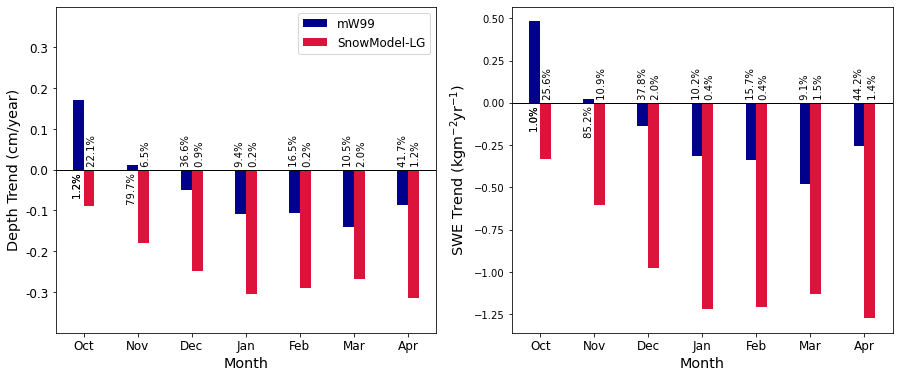

In [5]:
def product_comparer():

    mask_values = mask.get('mask')
    
    monthlist = ["10","11","12","01","02","03","04"]

    statistics = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

    yearlist = list(range(2003,2018))
    grid_res = (361,361)
    
    for product, dat_type, month in itertools.product(['snowmodel','mw99'], ['depth','SWE'], monthlist):

        mean_depth_list = []

        for year in yearlist:

            snow_depth = get_field(product,month=month,year=year,resolution=361,variable=dat_type)['field']

            snow_depth = ma.masked_where(snow_depth ==0, snow_depth)

            snow_depth = select_region('basin',snow_depth,pole_hole=88)

            mean_depth_list.append(np.nanmean(snow_depth))
            
        # Calculate trend for that month over several years

        statistics[product]['trend'][dat_type][month] = linregress(yearlist,mean_depth_list)

        statistics[product]['variance'][dat_type][month] = np.nanstd(mean_depth_list)
        
    return(statistics)

    
################################################################################################################
def plot_variability(dat_type,statistics):
    
    sm_slopes, sm_significances, mw_slopes, mw_significances = [], [], [], []

    for month in monthlist:
        sm_slopes.append(statistics['snowmodel']['variance'][dat_type][month])
        mw_slopes.append(statistics['mw99']['variance'][dat_type][month])

    # Make the plot

    fig = plt.figure(figsize=(8,5))

    x = np.array(range(7))

    plt.bar(x-0.1, mw_slopes, width=0.2, color='darkblue', align='center',label='mW99')
    plt.bar(x+0.1, sm_slopes, width=0.2, color='crimson', align='center',label='SnowModel')
    if dat_type == 'depth':
        plt.ylabel(fr'{dat_type} Variability (m)', fontsize = 'x-large')
    else:
        plt.ylabel(fr'{dat_type} Variability (kgm$^{-2}$/year)', fontsize = 'x-large')

    plt.xticks(ticks=[0,1,2,3,4,5,6],labels=["Oct","Nov","Dec","Jan","Feb","Mar","Apr"],fontsize='large')

    plt.legend(fontsize='large')

    plt.xlabel('Month', fontsize = 'x-large')

    plt.savefig(f'/home/robbie/Dropbox/SM_Thickness/paper/figures/main_figs/{dat_type}_IAV_bar_plot.png', dpi=600, bbox_inches='tight')

    plt.show()
    
##################################################################################################################

def plot_trends(statistics):
    
            
    fig, axs = plt.subplots(1,2,figsize=(15,6))

    for dat_type, ax in zip(['depth','SWE'], axs):
        
        print(dat_type)

        sm_slopes, sm_signif, mw_slopes, mw_signif = [], [], [], []


        for month in monthlist:

            sm_slopes.append(statistics['snowmodel']['trend'][dat_type][month][0])
            sm_signif.append(statistics['snowmodel']['trend'][dat_type][month][3])
            mw_slopes.append(statistics['mw99']['trend'][dat_type][month][0])
            mw_signif.append(statistics['mw99']['trend'][dat_type][month][3])

        x = np.array(range(7))

        ax.bar(x-0.1, mw_slopes, width=0.2, color='darkblue', align='center',label='mW99')
        ax.bar(x+0.1, sm_slopes, width=0.2, color='crimson', align='center',label='SnowModel-LG')

        if dat_type == 'depth':
            ax.set_ylim(-0.004,0.004)
            ax.set_yticks(ticks = np.arange(-0.003,0.0031,0.001))
            ax.set_yticklabels(np.around(np.arange(-0.003,0.0031,0.001)*100, decimals=1), fontsize = 'large')
            ax.set_ylabel('Depth Trend (cm/year)', fontsize = 'x-large')

        elif dat_type == 'SWE':
            ax.set_ylabel(r'SWE Trend (kgm$^{-2}$yr$^{-1}$)', fontsize = 'x-large')

        for i, (mw_value,mw_signif,sm_value,sm_signif) in enumerate(zip(mw_slopes,
                                                     mw_signif,
                                                     sm_slopes,
                                                     sm_signif)):

            mwverticalalignment = 'top' if mw_value > 0 else 'bottom'
            smverticalalignment = 'top' if sm_value > 0 else 'bottom'


            ax.annotate(f' {np.round(mw_signif*100,decimals=1)}% ', 
                         (i-0.1,0),
                         rotation = 90,
                         verticalalignment=mwverticalalignment,
                         horizontalalignment='center',
                         color='k')
            
            ax.annotate(f' {np.round(sm_signif*100,decimals=1)}% ', 
                         (i+0.15,0),
                         rotation = 90,
                         verticalalignment=smverticalalignment,
                         horizontalalignment='center',
                         color='k')
            
            if mw_signif < 0.05:
                ax.annotate(f' {np.round(mw_signif*100,decimals=1)}% ', 
                         (i-0.1,0),
                         rotation = 90,
                         verticalalignment=mwverticalalignment,
                         horizontalalignment='center',
                         color='k')
                
                
            
            
            
        ax.axhline(y=0, color='k', linewidth = 1)



        ax.set_xticks(ticks=[0,1,2,3,4,5,6])
        ax.set_xticklabels(["Oct","Nov","Dec","Jan","Feb","Mar","Apr"],fontsize='large')

        ax.set_xlabel('Month', fontsize = 'x-large')


    axs[0].legend(fontsize='large')

    plt.savefig(f'/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper/Figures/trends_bar_plot.png', dpi=600, bbox_inches='tight')

    plt.show()

###############################################################################################################    
    
    
statistics = product_comparer()

plot_trends(statistics)
# plot_variability('SWE',statistics)
# plot_variability('depth',statistics)

# This code calculates the average of the standard deviations at each grid point

In [11]:
def product_comparer(yearlist=list(range(2003,2018)),
                     grid_res = (361,361)):

    mask_values = mask.get('mask')
    
    global band_maps
            
    band_maps = {'SWE':{'snowmodel' : [],
                        'mw99'      : []},
                 'depth':{'snowmodel' : [],
                          'mw99'      : []}}
    
    monthlist = ["10","11","12","01","02","03","04"]
    
    statistics = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    
    for product, dat_type, month in itertools.product(['snowmodel','mw99'],
                                                      ['depth','SWE'],
                                                      monthlist,
                                                     ): 
        
        print(product,dat_type,month)

        snow_fields = []

        for year in yearlist:

            snow_depth = get_field(product,month=month,year=year,resolution=361,variable=dat_type)['field']

            snow_depth = ma.masked_where(snow_depth ==0, snow_depth)

            snow_depth = select_region('basin',snow_depth,pole_hole=88)
#                     snow_depth = select_type('myi',snow_depth, year = year, month = month)

            snow_fields.append(snow_depth)

        std = np.nanstd(np.array(snow_fields),axis=0)

        band_maps[dat_type][product].append(std)

        average_variability = np.nanmean(std)

        statistics['variance'][dat_type][month] = average_variability

        ones = np.ones((361,361))
        trend_mask  = select_region('basin',ones)

        snow_fields = np.array(snow_fields)

        # Make a list of twelve year timeseries                

        list_of_lists = []

        for i, j in itertools.product(range(361),range(361)):
            if trend_mask[i,j] == 1:
                anomaly_series = list(snow_fields[:,i,j])
                list_of_lists.append(anomaly_series)

        # For each timeseries in the list, filter nans. 
        # This involves making a time axis for each.
        # Sore this information in a list of tuples, timeseries and time axis

        list_of_list_tuples = [ cleaner(yearlist,sublist) for sublist in list_of_lists ]                 

        # Iterate through this list of timeseries and calculate the trend for each

        all_trends = np.array([linregress(x,y)[0] for x,y in list_of_list_tuples if len(x) > 2])
        significance = np.array([linregress(x,y)[3] for x,y in list_of_list_tuples if len(x) > 2])

        # Filter out the nans (if there are any?)

        not_nan_array = ~ np.isnan(all_trends)
        clean_trends = all_trends[not_nan_array]
        clean_significance = significance[not_nan_array]

        # Make a subset of this list of trends that just includes significant trends

        significant_trends = ma.masked_where(clean_significance < 0.05, clean_trends)
        significant_trends = ma.filled(significant_trends.astype(float), 0)
# significant_trends = ma.filled(significant_trends.astype(float), np.nan)
        # Calculate an average of these significant trends

        mean_trend = np.nanmean(significant_trends)
        mean_variability = np.nanmean(significance)

        statistics[product]['trend'][dat_type][month] = mean_trend
        statistics[product]['variance'][dat_type][month] = mean_variability

    return(statistics)
    

statistics = product_comparer()

for dat_type, product in itertools.product(['SWE','depth'],['snowmodel', 'mw99']):

    ave_map = np.nanmean(np.array(band_maps[dat_type][product]),axis=0).copy()

    band_maps[dat_type][product].append(ave_map)

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


snowmodel depth 10
snowmodel depth 11
snowmodel depth 12
snowmodel depth 01
snowmodel depth 02
snowmodel depth 03
snowmodel depth 04
snowmodel SWE 10
snowmodel SWE 11
snowmodel SWE 12
snowmodel SWE 01
snowmodel SWE 02
snowmodel SWE 03
snowmodel SWE 04
mw99 depth 10
mw99 depth 11
mw99 depth 12
mw99 depth 01
mw99 depth 02
mw99 depth 03
mw99 depth 04
mw99 SWE 10
mw99 SWE 11
mw99 SWE 12
mw99 SWE 01
mw99 SWE 02
mw99 SWE 03
mw99 SWE 04


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


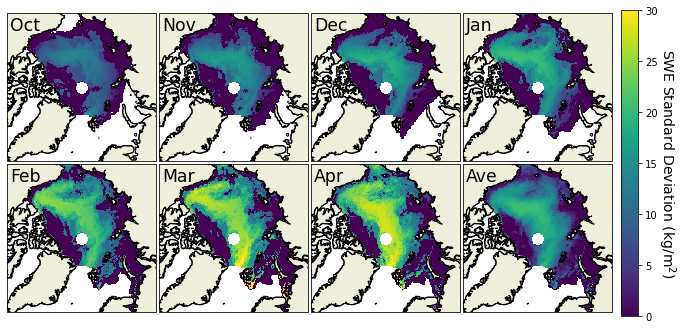

In [12]:
winter_months = month_names[-3:] + month_names[:4]
winter_months.append('Ave')

fig = plt.figure(figsize=(12,6))

for subplot_counter, field in enumerate(band_maps['SWE']['mw99'], 1):
    
    ax = plt.subplot(2,4,subplot_counter,projection=ccrs.NorthPolarStereo())
                                           
    ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
    ax.coastlines(resolution='110m')

    ax.set_extent([-180, 180, 90, 68], ccrs.PlateCarree())
        
    vmin, vmax = 0, 30

    ax.annotate(winter_months[subplot_counter-1],
                      xy = (0.02,0.98),xycoords='axes fraction',va='top',
                      ha='left',fontsize="xx-large",color='k')

    panel = ax.pcolormesh(np.array(mask.get('lon')), np.array(mask.get('lat')), np.array(field),
                        vmin = vmin, vmax = vmax,
                 transform=ccrs.PlateCarree(),zorder=0)
    
    
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=-0.22)

# add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8

cb_ax = fig.add_axes([0.81, 0.145, 0.02, 0.707])
cbar = fig.colorbar(panel, cax=cb_ax)

# plt.subplots_adjust(wspace=0.01, hspace=-0.2)

# plt.annotate(r'SWE Standard Deviation (kg/m$^2$)',
#              xy = (0.9,0.5),
#              xycoords="figure fraction",
#              rotation=270,
#              fontsize="x-large",
#              va='center')

cbar.set_label(r'SWE Standard Deviation (kg/m$^2$)', labelpad=20, size=14, rotation=270)

plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper/Figures/errorbands.png',
            dpi=600,bbox_inches='tight')

plt.show()

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


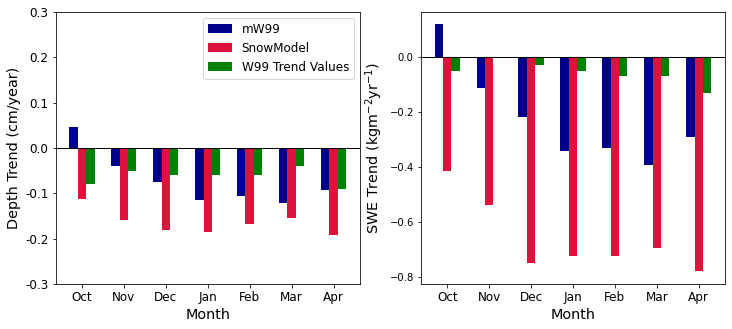

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

for ax,dat_type in zip([ax2,ax1],['SWE','depth']):

    sm_slopes, sm_significances, mw_slopes, mw_significances = [], [], [], []

    for month in monthlist:
        sm_slopes.append(statistics['snowmodel']['trend'][dat_type][month])
        mw_slopes.append(statistics['mw99']['trend'][dat_type][month])

    x = np.array(range(7))

    ax.bar(x-0.2, mw_slopes, width=0.2, color='darkblue', align='center',label='mW99')
    ax.bar(x, sm_slopes, width=0.2, color='crimson', align='center',label='SnowModel')
    ax.bar(x+0.2, np.array(W99_slopes[dat_type]), width=0.2, color='g', align='center',label='W99 Trend Values')

    if dat_type == 'depth':
        ax.set_ylim(-0.003,0.003)
        ax.set_yticks(ticks = np.arange(-0.003,0.0031,0.001))
        ax.set_yticklabels(np.around(np.arange(-0.003,0.0031,0.001)*100, decimals=1),
                   fontsize = 'large')
        ax.set_ylabel('Depth Trend (cm/year)', fontsize = 'x-large')

    elif dat_type == 'SWE':
        ax.set_ylabel(r'SWE Trend (kgm$^{-2}$yr$^{-1}$)', fontsize = 'x-large')



    ax.set_xticks(ticks=[0,1,2,3,4,5,6])
    ax.set_xticklabels(["Oct","Nov","Dec","Jan","Feb","Mar","Apr"],fontsize='large')

    ax.set_xlabel('Month', fontsize = 'x-large')
    ax.axhline(y=0, color='k', linewidth = 1)
    
    
ax1.legend(fontsize='large')

# THIS IS NOT THE RIGHT FIGURE TO SAVE
# overleaf_dir = '/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper/Figures/'
# plt.savefig(f'{overleaf_dir}trends_bar_plot_with_w99.png', dpi=600, bbox_inches='tight')

plt.show()
    


In [ ]:
def ew_mean(list_of_arrays):
    ave_vars = []
    
    for i in list_of_arrays:
        ave_vars.append(np.nanmean(i))
        
    return(ave_vars)

# Plotter

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

x = np.array(range(7))

########################################################

ax1.bar(x-0.2, ew_mean(band_maps['depth']['mw99'])[:-1], width=0.2, color='darkblue', align='center',label='mW99')
ax1.bar(x, ew_mean(band_maps['depth']['snowmodel'])[:-1], width=0.2, color='crimson', align='center',label='SnowModel')
ax1.bar(x+0.2, W99_IAV['depth'], width=0.2, color='g', align='center',label='W99 IAV Values')

ax1.set_xticks(ticks=[0,1,2,3,4,5,6])
ax1.set_xticklabels(["Oct","Nov","Dec","Jan","Feb","Mar","Apr"],fontsize='large')
ax1.set_yticks(ticks = np.linspace(0,0.07,8))
ax1.set_yticklabels(np.around(np.linspace(0,0.07,8)*100, decimals=0), fontsize = 'large')

ax1.legend(fontsize='large')

ax1.set_xlabel('Month', fontsize = 'x-large')
ax1.set_ylabel('Depth Interannual Variability (cm)', fontsize = 'x-large')

#########################################################

ax2.bar(x-0.2, ew_mean(band_maps['SWE']['mw99'])[:-1], width=0.2, color='darkblue', align='center',label='mW99')
ax2.bar(x, ew_mean(band_maps['SWE']['snowmodel'])[:-1], width=0.2, color='crimson', align='center',label='SnowModel')
ax2.bar(x+0.2, W99_IAV['SWE'], width=0.2, color='g', align='center',label='W99 IAV Values')

ax2.set_xticks(ticks=[0,1,2,3,4,5,6])
ax2.set_xticklabels(["Oct","Nov","Dec","Jan","Feb","Mar","Apr"],fontsize='large')
# ax2.set_yticks(ticks = np.linspace(0,0.07,8))
# ax2.set_yticklabels(np.around(np.linspace(0,0.07,8)*100, decimals=0),
#            fontsize = 'large')

# plt.legend(fontsize='large')

ax2.set_xlabel('Month', fontsize = 'x-large')
ax2.set_ylabel(r'SWE Interannual Variability (kgm$^{-2}$)', fontsize = 'x-large')


overleaf_dir = '/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper/Figures/'
plt.savefig(f'{overleaf_dir}IAV_bar_plot.png', dpi=600,bbox_inches='tight')

plt.show()

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
def variability_comparer():
    
    result = {}
    
    for product in ['SM', 'mW99']:

        result[product] = {}

        monthlist = ["10","11","12","01","02","03","04"]

        climatology_statistic = []

        for month in monthlist:

            # What years do you want to average

            yearlist = list(range(2010,2018))
            grid_res = (361,361)

            # Make some 3D arrays and fill them with data. 
            # One array will have everything, another will be filled with FYI, another with MYI

            album = np.full((grid_res[0],grid_res[1],len(yearlist)), np.nan)

            for counter, year in enumerate(yearlist):
                
                data_dir = '/home/robbie/Dropbox/SM_Thickness/data/Components/'

                with xr.open_dataset(f'{data_dir}{year}_components.nc') as data:

                    ds_month = data.where(int(month) == data.month, drop=True)

                    snow_cont = np.array(ds_month[product])[0]
                    freeboard_cont = np.array(ds_month['free'])[0]

                    thickness = snow_cont + freeboard_cont
                    
                snow_depth = get_field('snowmodel',month,str(year),resolution=361,variable='depth')['field']

                masked_thickness = ma.masked_where(snow_depth ==0, thickness)

                masked_thickness = np.ma.filled(masked_thickness.astype(float), np.nan)

                album[:,:,counter] = masked_thickness

            # This is a single field, each pixel represents the average snow depth at that point over the years.

            climatology_field = np.nanmean(album,axis=2)

            result[product][month] = climatology_field

            climatology_statistic.append(np.nanmean(climatology_field))
    
    return(result)

a = variability_comparer()

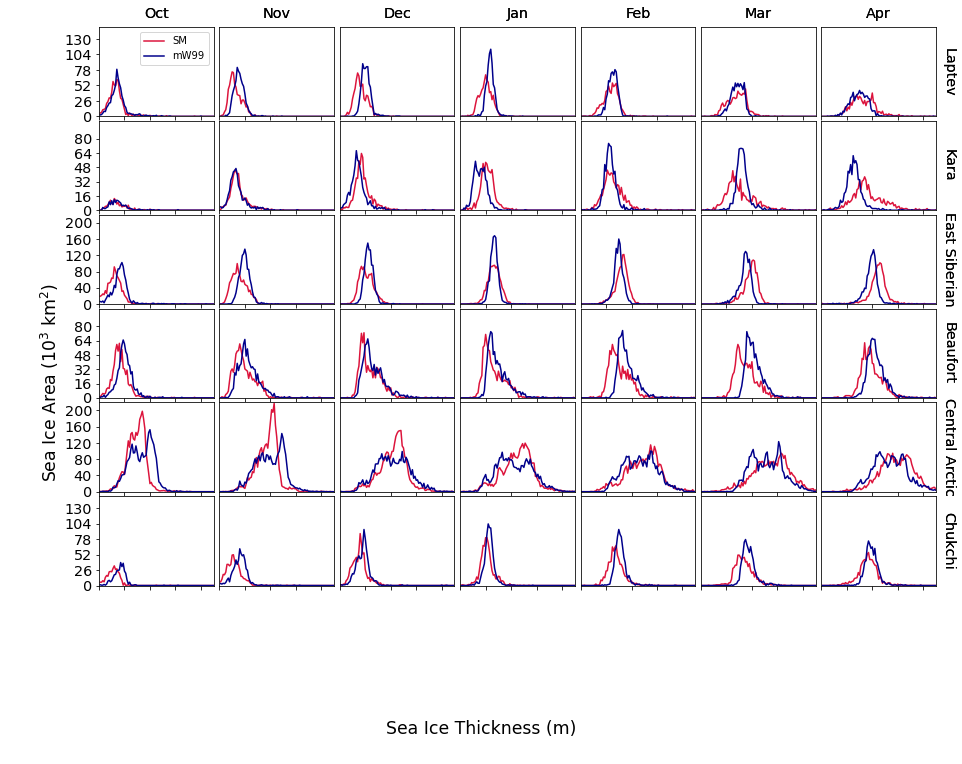

In [33]:
bin_structure = np.arange(0,8,0.05)
monthlist = ["10","11","12","01","02","03","04"]

region_mask = mask.get('mask')

fig = plt.figure(figsize=(15,12))

subplot_counter = 1

r_codes  = {"Lakes":0,
        "Oceans":1,
        "Okhotsk":2,
        "Bering":3,
        "Hudson":4,
        "St Lawrence":5,
        "Baffin":6,
        "Greenland":7,
        "Barents":8,
        "Kara":9,
        "Laptev":10,
        "East Siberian":11,
        "Chukchi":12,
        "Beaufort":13,
        "Canadian Archipelago":14,
        "Central Arctic":15,
        "Land":20,
        "Coast":21}

for region in ["Laptev","Kara","East Siberian","Beaufort","Central Arctic","Chukchi"]:
    
    region_code = r_codes[region]
    
    for month in monthlist:
        
        ax = plt.subplot(7,7,subplot_counter)

        output = {}

        for product in ['SM','mW99']:

            data = a[product][month]

            # Mask out peripheral regions

            masked_data = ma.masked_where(np.isin(region_mask, [region_code],invert=True), data)

            masked_data = np.ma.filled(masked_data.astype(float), np.nan)

            serial_data = masked_data.ravel()

            # Clean Data

            not_nan_array = ~ np.isnan(serial_data)
            clean_array = serial_data[not_nan_array]

            stats = plt.hist(clean_array,bins=bin_structure,alpha=0)

            if product == 'SM':
                color = 'crimson'
            else:
                color = 'darkblue'

            ax = plt.plot(stats[1][1:],np.array(stats[0])*623,label=product,color=color)
            
            if region in ['Central Arctic','East Siberian']:
                ymax = 220_000
            elif region == 'Barents':
                ymax = 60_000
            elif region in ['Kara','Beaufort']:
                ymax = 100_000
            else:
                ymax = 150_000
                
            ax = plt.xlim(0,4.5)
            ax = plt.ylim(0,ymax)
            
            # Make y ticks
            
            yticks = np.linspace(0,ymax-20_000,6)

            if subplot_counter in [1,8,15,22,29,36,43]:
                
                plt.yticks(ticks=yticks,labels= [int(i) for i in yticks/1000], fontsize='x-large'    )
            else:
                plt.yticks(ticks=[])

            # Make x ticks
            
            xticks = np.linspace(0,4,5)
            
            if subplot_counter < 43:
                plt.xticks(ticks=xticks,labels=[])
            else:

                plt.xticks(xticks, fontsize='x-large')
                

            if subplot_counter in [7,14,21,28,35,42,49]:

                ax = plt.annotate(region,xy = (1.05,0.5),
                                  xycoords='axes fraction',
                                  va='center',
                                  fontsize='x-large',
                                  rotation=270)
                
            if subplot_counter < 8:

                ax = plt.annotate(month_name_list[subplot_counter-1],
                                  xy = (0.5,1.1),xycoords='axes fraction',
                                  fontsize="x-large",ha='center')
            
            if subplot_counter == 1:
        
                plt.legend()

        subplot_counter +=1
        
plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.annotate(r"Sea Ice Area (10$^3$ km$^2$)",
                 xy = (0.04,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

plt.annotate("Sea Ice Thickness (m)",
                 xy = (0.5,0.04),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')

# plt.savefig("../paper/figures/SIT_dist_full_breakdown.png",dpi=600,bbox_inches='tight')


plt.show()

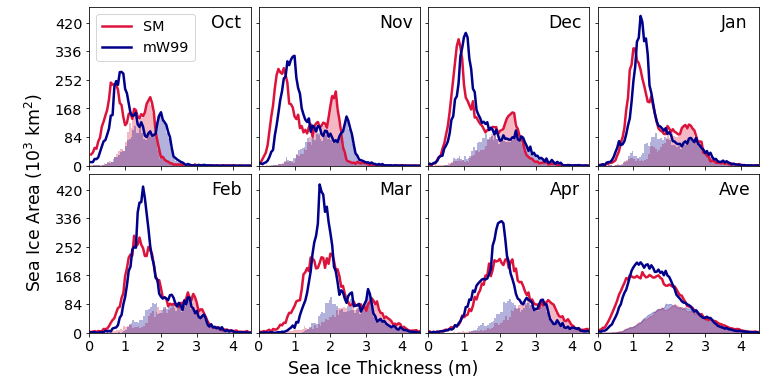

In [40]:
bin_structure = np.arange(0,8,0.05)
monthlist = ["10","11","12","01","02","03","04"]

region_mask = mask.get('mask')

fig = plt.figure(figsize=(12,6))

output_data = {'CASM':[],
                'CAmW99':[],
                'basinSM':[],
                'basinmW99':[]}

for subplot_counter, month in zip(range(1,8), monthlist):
    
    ax = plt.subplot(2,4,subplot_counter)

    
    for (mode, product) in itertools.product(['CA','basin'], ['SM','mW99']):
    
        data = a[product][month]

        # Mask out peripheral regions

        if mode == 'CA':

            masked_data = ma.masked_where(np.isin(region_mask, [15],invert=True), data)

        elif mode == 'basin':

            masked_data = ma.masked_where(np.isin(region_mask, [8,9,10,11,12,13,15],invert=True), data)

        masked_data = np.ma.filled(masked_data.astype(float), np.nan)

        serial_data = masked_data.ravel()

        # Clean Data

        not_nan_array = ~ np.isnan(serial_data)
        clean_array = serial_data[not_nan_array]

        if product == 'SM':
            color = 'crimson'
        elif product == 'mW99':
            color = 'darkblue'

        if mode == 'CA':
            stats = plt.hist(clean_array,bins=bin_structure,
                         alpha=0.3,color=color)
        elif mode == 'basin':
            stats = plt.hist(clean_array,bins=bin_structure,
                         alpha=0,color=color)


            ax = plt.plot(stats[1][1:],np.array(stats[0]),
                          label=product,color=color,linewidth=2.5,alpha=1)
            
        output_data[f'{mode}{product}'].append(stats[0])
        

    ymax = 750

    ax = plt.xlim(0,4.5)
    ax = plt.ylim(0,ymax)

    # Make y ticks

    yticks = np.linspace(0,0.9*ymax,6)

    if subplot_counter in [1,5]:

        plt.yticks(ticks=yticks,labels= [int(i) for i in yticks*0.623], fontsize='x-large'    )

    else:
        plt.yticks(ticks=yticks, labels=[])


    # Make x ticks

    xticks = np.linspace(0,4,5)

    if subplot_counter < 5:

        plt.xticks(ticks=xticks,labels=[])

    else:

        plt.xticks(xticks, fontsize='x-large')

    ax = plt.annotate(month_name_list[subplot_counter-1],
                          xy = (0.85,0.87),xycoords='axes fraction',
                          fontsize="xx-large",ha='center')

    if subplot_counter == 1:

        plt.legend(loc='upper left',fontsize='x-large')

# Comment this out first run #


ax = plt.subplot(2,4,8)

for key in lines.keys():
    
    if key[-2:] == 'SM':
        color = 'crimson'
    else:
        color = 'darkblue'
    
    if key[:2] == 'CA':
        ax.fill_between(stats[1][1:], np.zeros(stats[1][1:].shape), lines[key], alpha=0.3, color=color)
    else:
        ax.plot(stats[1][1:], lines[key], color = color, lw=2.5)

ax = plt.annotate('Ave',
                      xy = (0.85,0.87),xycoords='axes fraction',
                      fontsize="xx-large",ha='center')


ymax = 750

ax = plt.xlim(0,4.5)
ax = plt.ylim(0,ymax)

# Make y ticks

yticks = np.linspace(0,0.9*ymax,6)

plt.yticks(ticks=yticks, labels=[])


# Make x ticks

xticks = np.linspace(0,4,5)

plt.xticks(xticks, fontsize='x-large')

##########################################
        
plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.annotate(r"Sea Ice Area (10$^3$ km$^2$)",
                 xy = (0.03,0.5),
                 xycoords="figure fraction",
                 rotation=90,
                 fontsize="xx-large",
                 va='center')

plt.annotate("Sea Ice Thickness (m)",
                 xy = (0.5,0.03),
                 xycoords="figure fraction",
                 fontsize="xx-large",
                 ha='center')

plt.savefig(f'/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper/Sup_Figs/histograms.png',
            dpi=600,bbox_inches='tight')


plt.show()

dict_keys(['CASM', 'CAmW99', 'basinSM', 'basinmW99'])
159
159
159
159
159
159
159


(0.0, 4.5)

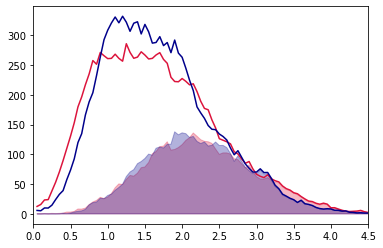

In [35]:
print(output_data.keys())

lines = {}

for i in output_data['CASM']:
    print(len(i))

for key in output_data.keys():
    
    lines[key] = np.nanmean(output_data[key], axis=0)
    
# plot_dict = {'CASM':}

for key in lines.keys():
    
    if key[-2:] == 'SM':
        color = 'crimson'
    else:
        color = 'darkblue'
    
    if key[:2] == 'CA':
        plt.fill_between(stats[1][1:], np.zeros(stats[1][1:].shape), lines[key], alpha=0.3, color=color)
    else:
        plt.plot(stats[1][1:], lines[key], color = color)
    
plt.xlim(0,4.5)

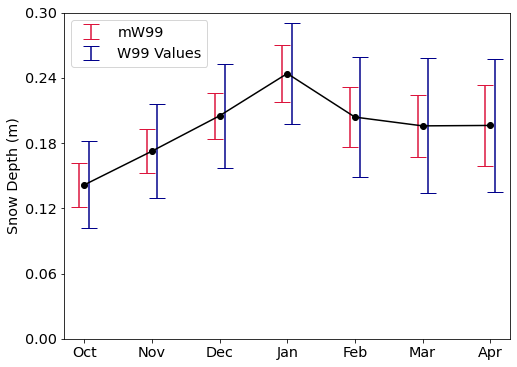

In [38]:
def variability_comparer(product):
    
    monthlist = ["10","11","12","01","02","03","04"]

    final_climatology = []
    final_err_climatology = []

    for month in monthlist:

        # What years do you want to average

        yearlist = list(range(2003,2018))
        grid_res = (361,361)

        # Make some 3D arrays and fill them with data. 
        # One array will have everything, another will be filled with FYI, another with MYI

        depth_album = np.full((grid_res[0],grid_res[1],len(yearlist)), np.nan)

        counter = 0
        for year in yearlist:
            
            snow_depth = get_field(product,month,str(year),resolution=361,variable='depth')['field']

#             snow_depth = get_field('snowmodel',month,str(year),resolution=361,variable='depth')['field']

            snow_depth = ma.masked_where(snow_depth ==0, snow_depth)

            snow_depth = np.ma.filled(snow_depth.astype(float), np.nan)

            depth_album[:,:,counter] = snow_depth

            counter +=1

        # Calculate spatially varying snow climatologies and break down into FYI/MYI

        # This is a single field, each pixel represents the average snow depth at that point over the years.

        climatology = np.nanmean(depth_album,axis=2)

        climatology_err = np.nanstd(depth_album,axis=2)

        final_climatology.append(np.nanmean(climatology))
        
        final_err_climatology.append(np.nanmean(climatology_err))

    W99_depth_IAV = np.array([4.0,4.3,4.8,4.6,5.5,6.2,6.1])/100


    fig, ax = plt.subplots(figsize=(8,6))

    trans1 = ax.transData + ScaledTranslation(-5/72, 0, fig.dpi_scale_trans)

    trans2 = ax.transData + ScaledTranslation(+5/72, 0, fig.dpi_scale_trans)

    main = ax.plot(month_name_list,final_climatology, 'k-', marker='o')

    er1 = ax.errorbar(month_name_list,final_climatology,
                      yerr=final_err_climatology,
                      color='crimson',capsize=8,
                      transform=trans1, ls = 'none',
                      label = product)

    er2 = ax.errorbar(month_name_list,final_climatology
                      ,yerr=W99_depth_IAV,color='darkblue',
                      capsize=8, transform=trans2, 
                      ls='none', label = 'W99 Values')

    plt.legend(fontsize='x-large')
    plt.ylim(0,0.3)
    plt.yticks(np.linspace(0,0.3,6),fontsize='x-large')
    plt.xticks(month_name_list,fontsize='x-large')
    plt.ylabel('Snow Depth (m)',fontsize='x-large')
#     plt.savefig(f"../paper/figures/{product}_IAV_comparison.png",dpi=600,bbox_inches='tight')
    plt.show()

# variability_comparer('snowmodel')
variability_comparer('mW99')

3.3.0
0.18.0


/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C hea

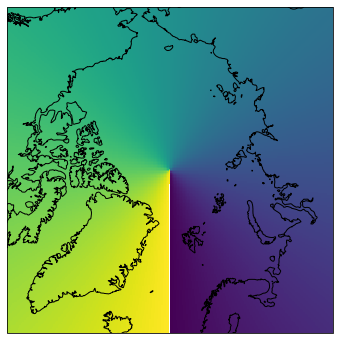

In [1]:
from cartoplot import cartoplot
from cartopy.util import add_cyclic_point
import mask
import numpy as np
import math
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import matplotlib
print(matplotlib.__version__)
print(cartopy.__version__)



lons = mask.get('lon')
lats = mask.get('lat')
data = (lons).copy()

# # data[:,-1] = 1000
# lons[:,-1] = 360

fig = plt.figure(figsize=(6,6))    
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.pcolormesh(np.array(lons),np.array(lats), np.array(data),transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
ax.coastlines()

3.1.3
0.18.0


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


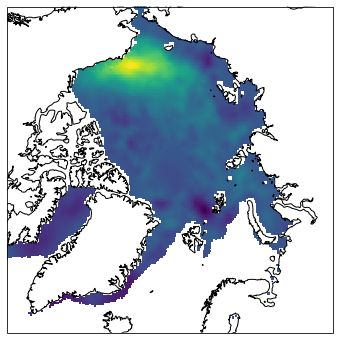

In [23]:
from netCDF4 import Dataset
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Double check the versions

import cartopy
import matplotlib
print(matplotlib.__version__)
print(cartopy.__version__)

# Import the data

# dat = Dataset('/home/robbie/Dropbox/Data/IMV/icemotion_daily_nh_25km_20140101_20141231_v4.1.nc')
dat = Dataset('/home/robbie/my_data.nc')
lons = dat['longitude']
lats = dat['latitude']
data = dat['u']

# Make the plot

fig = plt.figure(figsize=(6,6))    
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.pcolormesh(lons, lats, data ,transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
ax.coastlines()

In [8]:
import xarray as xr
import numpy as np

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
data_vars = {'u':(['x','y'],np.array(data))}


ds = xr.Dataset(data_vars = data_vars,
                coords={'longitude':(['x','y'],lons),
                         'latitude':(['x','y'],lats)}    )

data_dir = '/home/robbie/'

ds.to_netcdf(f'{data_dir}my_data.nc','w')

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3.2.2
0.18.0


/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C hea

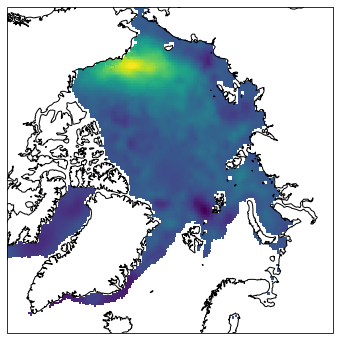

In [1]:
from netCDF4 import Dataset
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Double check the versions

import cartopy
import matplotlib
print(matplotlib.__version__)
print(cartopy.__version__)

# Import the data

dat = Dataset('/home/robbie/my_data.nc')
# my_data.nc is an ice motion vector file available (after logging in) here: https://nsidc.org/data/nsidc-0116
# The particular file I've used is icemotion_daily_nh_25km_20140101_20141231_v4.1.nc
# I've attached a stripped-down version to this report as a zip file, just unzip and name it my_data.nc
# It's a netcdf with an irregular grid (EASE equal area) with 2d arrays of lons, lats and data vals.

lons = dat['longitude']
lats = dat['latitude']
data = dat['u']

# Make the plot

fig = plt.figure(figsize=(6,6))    
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.pcolormesh(lons, lats, data ,transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
ax.coastlines()
plt.show()